In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import timeit
import datetime
import pprint
import itertools
import pickle
import sklearn
import dask
import dask.dataframe as dd
import dask.array as da
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
import fastparquet
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

### Find new MSA-technology fields appearing after 1990

In [2]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq")\
.to_pandas()
dup_pats = pd.read_pickle("RawData/Cleaned/duplicate_pattext_0712.pkl").tolist()
# Get relevant US Patents
pdf = pdf.loc[~pdf["patent"].isin(dup_pats)]
# Add MSA subfield
pdf["msa_pc"] = list(zip(pdf["inv_msa"], pdf["primclass"]))

In [3]:
# Get number of primary class patents by MSA, and year of their first appearance
p2 = pdf.groupby(["inv_msa", "primclass"]).size()
# Only get primary classes with more than 50 patents
p2 = p2.loc[p2 >= 50].reset_index().rename(columns={0:"size"})
# Date of first appearance
p3 = pdf[["inv_msa", "primclass", "gyear"]].sort_values(["inv_msa", "primclass", "gyear"]).drop_duplicates(["inv_msa", "primclass"])
# Merge
p2 = p2.merge(p3, how="left", on=["inv_msa", "primclass"]).rename(columns={"gyear": "first_gyear"})

# New technology fields after 1990
p3 = p2.loc[p2["first_gyear"] >= 1990]

# Subfield
p3["msa_pc"] = list(zip(p3["inv_msa"], p3["primclass"]))

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Find related subfields
1. Find related MSA-subfields
2. Get the first year of appearance of new subfield
3. Get patents appearing in related subfield in subsequent 10 years of new subfield
4. Get patents of new subfield in each of the 10 years subsequent

In [4]:
# Primary class random sample
ns = fastparquet.ParquetFile("DataStore/2018-07-P2/Reg0726/reg_naics_name_sim_tr_0726.parq").to_pandas()
ns["op_msa_pc"] = list(zip(ns["op_inv_msa"], ns["op_primclass"]))
ns["tp_msa_pc"] = list(zip(ns["tp_inv_msa"], ns["tp_primclass"]))
ns = ns.loc[ns["op_msa_pc"].isin(p3["msa_pc"])]

In [5]:
# Find highly similar MSA-PC subfields
ns2 = ns.loc[ns["norm_sim_mean_docvecs_pc_msa"] >= 1.5, ["tp_msa_pc", "op_msa_pc",
"inv_msa_match", "year_group", "sim_mean_docvecs_pc_msa", "norm_sim_mean_docvecs_pc_msa"]].drop_duplicates()

ns3 = ns2[["tp_msa_pc", "op_msa_pc"]]

# Merge with first year
ns3 = ns3.merge(p3.add_prefix("op_"), how="left", on = ["op_msa_pc"]).drop(["op_inv_msa", "op_primclass"],1)

In [7]:
# Use only patents from relevant MSA-PC
p2 = pdf.loc[pdf["msa_pc"].isin(ns3["tp_msa_pc"]) | pdf["msa_pc"].isin(ns3["op_msa_pc"])]
# Group patents by msa_pc, grant year
%time pg = {n:g["patent"].tolist() for n,g in p2[["msa_pc", "gyear", "patent"]].groupby(["msa_pc", "gyear"])}

CPU times: user 4.74 s, sys: 46.1 ms, total: 4.78 s
Wall time: 4.89 s


In [28]:
list(pg.values())[10]

[7519546, 7526442, 7542932, 7567914, 7571125, 7593880]

In [31]:
list(pg.keys())[10]

(('Albany-Schenectady-Troy, NY', 705.0), 2009)

In [22]:
# Add a grant year for each of the 10 years following the first grant year of new subfield
ns4 = [list(zip([r1]*10, [r2]*10, [r3]*10, list(range(r3, r3+10)))) for r1,r2,r3\
       in zip(ns3["tp_msa_pc"], ns3["op_msa_pc"], ns3["op_first_gyear"])]
ns4 = [item for sublist in ns4 for item in sublist]
ns4 = pd.DataFrame({"tp_msa_pc": [i[0] for i in ns4],
                   "op_msa_pc": [i[1] for i in ns4],
                   "op_first_gyear": [i[2] for i in ns4],
                   "gyear": [i[3] for i in ns4],})

In [37]:
# Patents for each MSA-PC
ns4["tp_msa_pc_pats"] = [pg.get((mp, yr), np.nan) for mp, yr in zip(ns4["tp_msa_pc"], ns4["gyear"])]
ns4["op_msa_pc_pats"] = [pg.get((mp, yr), np.nan) for mp, yr in zip(ns4["op_msa_pc"], ns4["gyear"])]

In [34]:
ns4.to_pickle("DataStore/2018-08/related_field_pats_0913.pkl")

In [38]:
ns4.head()

,gyear,op_first_gyear,op_msa_pc,tp_msa_pc,tp_msa_pc_pats,op_msa_pc_pats,max_len
9,2001,1992,"(Atlanta-Sandy Springs-Marietta, GA, 707.0)","(New York-Northern New Jersey-Long Island, NY-...","[6185560, 6282533, 6285995, 6317736, 6317751, ...","[6226650, 6295526]",9
10,1995,1995,"(Colorado Springs, CO, 713.0)","(Colorado Springs, CO, 713.0)",[5469553],[5469553],1
13,1998,1995,"(Colorado Springs, CO, 713.0)","(Colorado Springs, CO, 713.0)",[5768391],[5768391],1
14,1999,1995,"(Colorado Springs, CO, 713.0)","(Colorado Springs, CO, 713.0)","[5991890, 6000037]","[5991890, 6000037]",2
15,2000,1995,"(Colorado Springs, CO, 713.0)","(Colorado Springs, CO, 713.0)","[6033441, 6058485, 6085321, 6108794, 6115814]","[6033441, 6058485, 6085321, 6108794, 6115814]",5


### Random pairs from related subfields

In [36]:
# Drop missing years
print(len(ns4))
ns4 = ns4.dropna(how="any")
print(len(ns4))
# Add max length of each list of patents
ns4["max_len"] = [max(len(i), len(j)) for i,j in zip(ns4["tp_msa_pc_pats"], ns4["op_msa_pc_pats"])]

def rand_list(l, nlen):
    try:
        s = np.random.choice(l, size=nlen, replace=True)
    except Exception:
        s = [np.nan]
    return s

rp = [list(zip(rand_list(i, nlen), rand_list(j, nlen))) for i,j, nlen \
      in zip(ns4["tp_msa_pc_pats"].tolist(), ns4["op_msa_pc_pats"].tolist(), ns4["max_len"].tolist())]
rp = [item for sublist in rp for item in sublist]

rs = pd.DataFrame({"tp": [i[0] for i in rp], "op": [i[1] for i in rp]})

# Drop missing values
rs = rs.dropna(how="any")

1036
1036


In [41]:
# Get similarity
def grouper(n, iterable):
    """
    >>> list(grouper(3, 'ABCDEFG'))
    [['A', 'B', 'C'], ['D', 'E', 'F'], ['G']]
    """
    iterable = iter(iterable)
    return iter(lambda: list(itertools.islice(iterable, n)), [])


import scipy.spatial.distance as distance
dms = ["ldavecs", "docvecs"]

print("Getting row values")
print(datetime.datetime.now())
pat_dict = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
pat_dict = dict(zip(pat_dict, range(len(pat_dict))))

l2 = rs.drop_duplicates()

for dm in dms:
    print((dm,"started"))
    print("Loading matrix and dict")
    print(datetime.datetime.now())
    # Store copy as array
    l3 = l2.loc[l2["tp"].isin(pat_dict.keys()) & l2["op"].isin(pat_dict.keys()), ["tp", "op"]].copy()

    if dm == "ldavecs":
        ncols = 60
    else:
        ncols = 100

    pm = fastparquet.ParquetFile("DataStore/2018-07-P2/ML/{0}_pats_0712.parq".format(dm))\
.to_pandas().values

    # Convert to chunks
    print("Getting chunks")
    print(datetime.datetime.now())
    # Split into chunks
    n_rows = 3000
    n_chunks = int(np.round(len(l3)/n_rows))
    tp_chunks = grouper(n_rows, pm[[pat_dict[p[1]] for p in l3["tp"].iteritems()]])
    op_chunks = grouper(n_rows, pm[[pat_dict[p[1]] for p in l3["op"].iteritems()]])
    del(pm)
    chunks = itertools.zip_longest(tp_chunks, op_chunks)

    print("Getting patent pair cosine similarity")
    print(datetime.datetime.now())
    # Cosine

    cos_dis = np.empty(len(l3))

    for r, c in enumerate(chunks):
        cos_dis[r*n_rows:r*n_rows+n_rows] = np.diag(distance.cdist(c[0],c[1], metric = "cosine"))

    l3["sim_{0}".format(dm)] = 1-cos_dis
    
    # Rename columns
    l2 = l2.merge(l3.drop_duplicates(), how = "left", on = ["tp", "op"])
    del(l3)
    print("finished")
    print(datetime.datetime.now())

Getting row values
2018-09-13 16:45:57.188260
('ldavecs', 'started')
Loading matrix and dict
2018-09-13 16:45:59.105423
Getting chunks
2018-09-13 16:46:19.076169
Getting patent pair cosine similarity
2018-09-13 16:46:20.500362
finished
2018-09-13 16:46:41.967570
('docvecs', 'started')
Loading matrix and dict
2018-09-13 16:46:41.967965
Getting chunks
2018-09-13 16:47:04.741460
Getting patent pair cosine similarity
2018-09-13 16:47:09.278009
finished
2018-09-13 16:48:06.355046


In [54]:
rs = l2.drop_duplicates()
print(len(rs))
# rs.to_pickle("DataStore/2018-08/related_field_pats_pairs_0913.pkl")

146291


In [55]:
# Merge with pdf
rs = rs.merge(pdf[["patent", "title", "gyear", "inv_msa", "primclass", "naics_name", "msa_pc"]].add_prefix("tp_"),
             how="left", left_on="tp", right_on="tp_patent").drop("tp_patent",1)
rs = rs.merge(pdf[["patent", "title", "gyear", "inv_msa", "primclass", "naics_name", "msa_pc"]].add_prefix("op_"),
             how="left", left_on="op", right_on="op_patent").drop("op_patent",1)

rs["primclass_match"] = (rs["tp_primclass"] == rs["op_primclass"])
rs["inv_msa_match"] = (rs["tp_inv_msa"] == rs["op_inv_msa"])

In [56]:
def get_year_group_10(x):
    if x in range(1975,1985):
        yg = "1975-85"
    elif x in range(1985,1995):
        yg = "1985-95"
    elif x in range(1995, 2005):
        yg = "1995-05"
    elif x in range(2005,2015):
        yg = "2005-15"
    else:
        yg = np.nan
    return yg

rs["year_group"] = rs["tp_gyear"].apply(get_year_group_10)

# Merge with year of first appearance for other patent MSA-PC
rs = rs.merge(ns3[["op_msa_pc", "op_first_gyear"]].drop_duplicates(), how="left", on="op_msa_pc")
print(len(rs))

# Add year from first appearance
rs["tp_yr_from_first"] = rs["tp_gyear"] - rs["op_first_gyear"]

# Merge with ns to get MSA-PC similarities
# rs = rs.merge(ns[["sim_mean_docvecs_pc_msa", "norm_sim_mean_docvecs_pc_msa", "year_group", 
#                   "tp_msa_pc", "op_msa_pc"]].drop_duplicates(["year_group", 
#                   "tp_msa_pc", "op_msa_pc"]), how="left", on=["year_group", 
#                   "tp_msa_pc", "op_msa_pc"])
print(len(rs))

146291
146291


In [65]:
# Remove same tp, op
rs = rs.loc[~(rs["tp"] == rs["op"])]
print(len(rs))

144674


In [57]:
rs.head()

,op,tp,sim_ldavecs,sim_docvecs,tp_title,tp_gyear,tp_inv_msa,tp_primclass,tp_naics_name,tp_msa_pc,...,op_gyear,op_inv_msa,op_primclass,op_naics_name,op_msa_pc,primclass_match,inv_msa_match,year_group,op_first_gyear,tp_yr_from_first
0,6295526,6282533,0.546434,0.116242,System and method for performing I/O-efficient...,2001,"New York-Northern New Jersey-Long Island, NY-N...",707.0,Computer and Peripheral Equipment,"(New York-Northern New Jersey-Long Island, NY-...",...,2001,"Atlanta-Sandy Springs-Marietta, GA",707.0,Computer and Peripheral Equipment,"(Atlanta-Sandy Springs-Marietta, GA, 707.0)",True,False,1995-05,1992,9
1,6295526,6324536,0.495427,0.215507,Method and system for providing interactive el...,2001,"New York-Northern New Jersey-Long Island, NY-N...",707.0,Computer and Peripheral Equipment,"(New York-Northern New Jersey-Long Island, NY-...",...,2001,"Atlanta-Sandy Springs-Marietta, GA",707.0,Computer and Peripheral Equipment,"(Atlanta-Sandy Springs-Marietta, GA, 707.0)",True,False,1995-05,1992,9
2,6226650,6334125,0.239687,0.270512,Method and apparatus for loading data into a c...,2001,"New York-Northern New Jersey-Long Island, NY-N...",707.0,Computer and Peripheral Equipment,"(New York-Northern New Jersey-Long Island, NY-...",...,2001,"Atlanta-Sandy Springs-Marietta, GA",707.0,Computer and Peripheral Equipment,"(Atlanta-Sandy Springs-Marietta, GA, 707.0)",True,False,1995-05,1992,9
3,6226650,6317751,0.525523,0.157075,Compliance archival data process and system,2001,"New York-Northern New Jersey-Long Island, NY-N...",707.0,Computer and Peripheral Equipment,"(New York-Northern New Jersey-Long Island, NY-...",...,2001,"Atlanta-Sandy Springs-Marietta, GA",707.0,Computer and Peripheral Equipment,"(Atlanta-Sandy Springs-Marietta, GA, 707.0)",True,False,1995-05,1992,9
4,6295526,6334125,0.072009,0.225754,Method and apparatus for loading data into a c...,2001,"New York-Northern New Jersey-Long Island, NY-N...",707.0,Computer and Peripheral Equipment,"(New York-Northern New Jersey-Long Island, NY-...",...,2001,"Atlanta-Sandy Springs-Marietta, GA",707.0,Computer and Peripheral Equipment,"(Atlanta-Sandy Springs-Marietta, GA, 707.0)",True,False,1995-05,1992,9


In [66]:
rs.to_pickle("DataStore/2018-08/related_field_pats_pairs_0913.pkl")

### Descriptive analysis

In [2]:
rs = pd.read_pickle("DataStore/2018-08/related_field_pats_pairs_0913.pkl")
len(rs)

566742

#### Primclass match vs non-match findings

In [67]:
rs2 = rs.loc[(rs["primclass_match"] == False), ["tp_yr_from_first", "inv_msa_match", 
    "sim_docvecs"]].groupby(["tp_yr_from_first", "inv_msa_match"]).mean().reset_index()

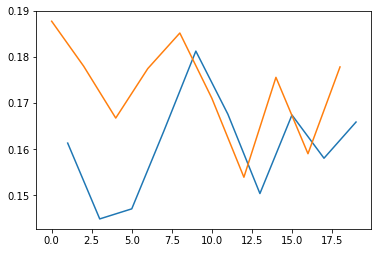

In [68]:
%matplotlib inline
rs2.loc[rs2["inv_msa_match"] == True, "sim_docvecs"].plot.line()
rs2.loc[rs2["inv_msa_match"] == False, "sim_docvecs"].plot.line()

In [69]:
rs3 = rs.loc[(rs["primclass_match"] == True), ["tp_yr_from_first", "inv_msa_match", 
    "sim_docvecs"]].groupby(["tp_yr_from_first", "inv_msa_match"]).mean().reset_index()

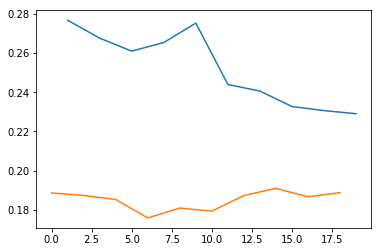

In [70]:
%matplotlib inline
rs3.loc[rs3["inv_msa_match"] == True, "sim_docvecs"].plot.line()
rs3.loc[rs3["inv_msa_match"] == False, "sim_docvecs"].plot.line()

In [71]:
rs3

,tp_yr_from_first,inv_msa_match,sim_docvecs
0,0,False,0.188628
1,0,True,0.276663
2,1,False,0.187328
3,1,True,0.267510
4,2,False,0.185301
5,2,True,0.260927
6,3,False,0.175900
7,3,True,0.265315
8,4,False,0.180930
9,4,True,0.275207


### Example

- Pretty much only ("San Francisco-Oakland-Fremont, CA", 709.0) has a good mix of *primclass_match*, *inv_msa_match*

In [96]:
rs2 = rs.loc[(rs["primclass_match"] == False) & (rs["inv_msa_match"] == True)]
rs3 = rs.loc[rs["tp_msa_pc"].isin(rs2["tp_msa_pc"]) \
             & (rs["primclass_match"] == False) & (rs["inv_msa_match"] == False)]

In [107]:
ex = rs.loc[rs["tp_msa_pc"] == ("San Francisco-Oakland-Fremont, CA", 709.0)]

In [111]:
ex[["sim_docvecs", "primclass_match", "inv_msa_match", "tp_yr_from_first"]]\
.groupby(["primclass_match", "inv_msa_match", "tp_yr_from_first"]).mean()

sim_docvecs
primclass_match inv_msa_match tp_yr_from_first             
False           False         0                    0.182599
                              3                    0.118997
                              4                    0.118151
                              5                    0.201104
                              6                    0.151357
                              7                    0.176185
                              8                    0.134379
                              9                    0.180031
                True          0                    0.104780
                              2                    0.052066
                              3                    0.150581
                              4                    0.159419
                              5                    0.178449
                              6                    0.163036
                              7                    0.168434
                              8                    0.142697
                              9                    0.186366
True            False         0                    0.149987
                              1                    0.206293
                              2                    0.164721
                              3                    0.163733
                              4                    0.131447
                              5                    0.170027
                              6                    0.164637
                              7                    0.166144
                              8                    0.166365
                              9                    0.157094

In [101]:
ex["inv_msa_match"].value_counts()

False    11806
Name: inv_msa_match, dtype: int64

In [98]:
rs3["tp_msa_pc"].value_counts()

(San Francisco-Oakland-Fremont, CA, 709.0)    838
(Seattle-Tacoma-Bellevue, WA, 713.0)           84
(San Francisco-Oakland-Fremont, CA, 717.0)     78
Name: tp_msa_pc, dtype: int64

In [102]:
rs2["tp_msa_pc"].value_counts()

(Seattle-Tacoma-Bellevue, WA, 715.0)            1003
(San Francisco-Oakland-Fremont, CA, 709.0)       595
(Orlando-Kissimmee-Sanford, FL, 438.0)           348
(San Francisco-Oakland-Fremont, CA, 717.0)       203
(Portland-Vancouver-Hillsboro, OR-WA, 713.0)     182
(San Francisco-Oakland-Fremont, CA, 719.0)       103
(Seattle-Tacoma-Bellevue, WA, 713.0)              76
(Atlanta-Sandy Springs-Marietta, GA, 713.0)       62
(Seattle-Tacoma-Bellevue, WA, 235.0)              61
(San Diego-Carlsbad-San Marcos, CA, 713.0)        22
(Portland-Vancouver-Hillsboro, OR-WA, 359.0)      18
(Atlanta-Sandy Springs-Marietta, GA, 709.0)        9
(Kansas City, MO-KS, 455.0)                        8
(Atlanta-Sandy Springs-Marietta, GA, 707.0)        6
Name: tp_msa_pc, dtype: int64

In [103]:
rs2.loc[rs2["tp_msa_pc"] == ("San Francisco-Oakland-Fremont, CA", 709.0)]

,op,tp,sim_ldavecs,sim_docvecs,tp_title,tp_gyear,tp_inv_msa,tp_primclass,tp_naics_name,tp_msa_pc,...,op_gyear,op_inv_msa,op_primclass,op_naics_name,op_msa_pc,primclass_match,inv_msa_match,year_group,op_first_gyear,tp_yr_from_first
8891,5187787,5191652,0.745578,0.104780,Method and apparatus for exploiting communicat...,1993,"San Francisco-Oakland-Fremont, CA",709.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 709.0)",...,1993,"San Francisco-Oakland-Fremont, CA",719.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 719.0)",False,True,1985-95,1993,0
8892,5457797,5471623,0.475425,0.166033,Lambda network having 2.sup.m-1 nodes in each ...,1995,"San Francisco-Oakland-Fremont, CA",709.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 709.0)",...,1995,"San Francisco-Oakland-Fremont, CA",719.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 719.0)",False,True,1995-05,1993,2
8893,5530865,5544320,0.714982,0.105682,Remote information service access system based...,1996,"San Francisco-Oakland-Fremont, CA",709.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 709.0)",...,1996,"San Francisco-Oakland-Fremont, CA",719.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 719.0)",False,True,1995-05,1993,3
8894,5530865,5519878,0.830082,0.086236,System for installing and configuring (groupin...,1996,"San Francisco-Oakland-Fremont, CA",709.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 709.0)",...,1996,"San Francisco-Oakland-Fremont, CA",719.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 719.0)",False,True,1995-05,1993,3
8895,5530865,5513324,0.769391,0.303185,Method and apparatus using network variables i...,1996,"San Francisco-Oakland-Fremont, CA",709.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 709.0)",...,1996,"San Francisco-Oakland-Fremont, CA",719.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 719.0)",False,True,1995-05,1993,3
8896,5530865,5544318,0.670455,0.099933,Asynchronous media server request processing s...,1996,"San Francisco-Oakland-Fremont, CA",709.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 709.0)",...,1996,"San Francisco-Oakland-Fremont, CA",719.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 719.0)",False,True,1995-05,1993,3
8897,5530865,5515508,0.752080,0.163800,Client server system and method of operation i...,1996,"San Francisco-Oakland-Fremont, CA",709.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 709.0)",...,1996,"San Francisco-Oakland-Fremont, CA",719.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 719.0)",False,True,1995-05,1993,3
8898,5530865,5481674,0.578551,0.097376,Method and apparatus mapping the physical topo...,1996,"San Francisco-Oakland-Fremont, CA",709.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 709.0)",...,1996,"San Francisco-Oakland-Fremont, CA",719.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 719.0)",False,True,1995-05,1993,3
8899,5530865,5526358,0.770563,-0.012777,Node management in scalable distributed comput...,1996,"San Francisco-Oakland-Fremont, CA",709.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 709.0)",...,1996,"San Francisco-Oakland-Fremont, CA",719.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 719.0)",False,True,1995-05,1993,3
8900,5615401,5696901,0.657829,0.219722,Remote information service access system based...,1997,"San Francisco-Oakland-Fremont, CA",709.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 709.0)",...,1997,"San Francisco-Oakland-Fremont, CA",719.0,Computer and Peripheral Equipment,"(San Francisco-Oakland-Fremont, CA, 719.0)",False,True,1995-05,1993,4


In [76]:
rs["tp_msa_pc"].value_counts()

(San Jose-Sunnyvale-Santa Clara, CA, 709.0)                    11806
(San Jose-Sunnyvale-Santa Clara, CA, 438.0)                     8598
(San Francisco-Oakland-Fremont, CA, 709.0)                      7966
(San Jose-Sunnyvale-Santa Clara, CA, 715.0)                     4073
(New York-Northern New Jersey-Long Island, NY-NJ-PA, 435.0)     3820
(Seattle-Tacoma-Bellevue, WA, 709.0)                            3732
(San Jose-Sunnyvale-Santa Clara, CA, 707.0)                     3689
(San Francisco-Oakland-Fremont, CA, 435.0)                      3247
(Boston-Cambridge-Quincy, MA-NH, 435.0)                         3199
(New York-Northern New Jersey-Long Island, NY-NJ-PA, 709.0)     3110
(San Jose-Sunnyvale-Santa Clara, CA, 370.0)                     2989
(San Jose-Sunnyvale-Santa Clara, CA, 1.0)                       2789
(San Jose-Sunnyvale-Santa Clara, CA, 257.0)                     2711
(Seattle-Tacoma-Bellevue, WA, 707.0)                            2247
(Rochester, NY, 399.0)            